In [2]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D,MaxPooling2D,Flatten,Conv1D
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split


import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import keras
from keras.layers import Input,Dense,Lambda
from keras.models import Model
import os
import numpy as np
from keras.preprocessing import image as image_p
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.image as mpimg
from keras.preprocessing import image
from  matplotlib import pyplot
from keras.layers.normalization import BatchNormalization
import cv2
import seaborn as sns
import random
from PIL import Image
from sklearn.utils import class_weight
from keras.layers import Reshape
import keras.backend as K

Using TensorFlow backend.


In [3]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12652137900814326756, name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3502306278245603769
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11408008501629722338
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5560074240
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2475990751557773292
 physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [8]:
i = 0
with open('data-localize'+str(i)+'.pckl','rb') as file:
        train_images,train_bboxes,train_labels,train_image_sizes,test_images,test_bboxes,test_labels,test_image_sizes = pickle.load(file)

In [4]:
#num_labels = len(np.unique(labels))

def iou_metric(y_true, y_pred):
    # iou as metric for bounding box regression
    # input must be as [x1, y1, x2, y2]
    
    # AOG = Area of Groundtruth box
    AoG = K.abs(K.transpose(y_true)[2] - K.transpose(y_true)[0] + 1) * K.abs(K.transpose(y_true)[3] - K.transpose(y_true)[1] + 1)
    
    # AOP = Area of Predicted box
    AoP = K.abs(K.transpose(y_pred)[2] - K.transpose(y_pred)[0] + 1) * K.abs(K.transpose(y_pred)[3] - K.transpose(y_pred)[1] + 1)

    # overlaps are the co-ordinates of intersection box
    overlap_0 = K.maximum(K.transpose(y_true)[0], K.transpose(y_pred)[0])
    overlap_1 = K.maximum(K.transpose(y_true)[1], K.transpose(y_pred)[1])
    overlap_2 = K.minimum(K.transpose(y_true)[2], K.transpose(y_pred)[2])
    overlap_3 = K.minimum(K.transpose(y_true)[3], K.transpose(y_pred)[3])

    # intersection area
    intersection = (overlap_2 - overlap_0 + 1) * (overlap_3 - overlap_1 + 1)

    # area of union of both boxes
    union = AoG + AoP - intersection
    
    # iou calculation
    iou = intersection / union

    # bounding values of iou to (0,1)
    iou = K.clip(iou, 0.0 + K.epsilon(), 1.0 - K.epsilon())

    return iou    

In [5]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions


base_model = ResNet50(
    input_shape=(224,224,3),
    weights='imagenet',
    include_top=True
)

cnn_base = Model(
    inputs=base_model.input,
    outputs=base_model.layers[-2].output
)
# to freeze layers
for layer in cnn_base.layers:
    layer.trainable = False

W0627 09:19:36.639309 139811103303424 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/moving_averages.py:211: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


102858752/102853048 [==============================] - 7s 0us/step


In [6]:
cnn_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [10]:
x = cnn_base.get_layer('activation_41').output
x = Conv2D(128, kernel_size=(3, 3), padding="same")(x)
x = MaxPooling2D(pool_size=(4, 4))(x)
x = BatchNormalization()(x)
x = Conv2D(4, kernel_size=(1, 1), padding="same")(x)
x = Reshape((4,),name='localization_output')(x)


y = base_model.layers[-1].output
y = BatchNormalization()(y)
y = Dense(16,activation='relu')(y)
y = BatchNormalization()(y)
y = Dense(test_labels.shape[1],activation='softmax',name='classification_output')(y)

losses = {
    "localization_output": "mean_squared_error",
    "classification_output": "categorical_crossentropy",
}
lossWeights = {"localization_output": 1.0, "classification_output": 1.0}

model = Model(inputs=cnn_base.input, outputs=[x])
model.compile(loss="mean_squared_error", optimizer="adam", metrics={'localization_output':['accuracy',iou_metric]})
#model.compile(loss='categorical_crossentropy', optimizer="adam", metrics={'classification_output':'accuracy'})
model.save_weights('resnet-localization2.hd5')

In [11]:
train_pred = []
test_pred = []

train_scores = []
test_scores = []

for i in range(5):
    #if i==0 or i==1:
    #    continue
    with open('data-localize'+str(i)+'.pckl','rb') as file:
        train_images,train_bboxes,train_labels,train_image_sizes,test_images,test_bboxes,test_labels,test_image_sizes = pickle.load(file)
    
    model.load_weights('resnet-localization2.hd5')
    history = model.fit(x=np.array(train_images),y={"classification_output": np.array(train_labels), "localization_output": np.array(train_bboxes)},batch_size=20,epochs=25,
                       validation_data=(np.array(test_images),{"classification_output": test_labels, "localization_output": np.array(test_bboxes)}))
#     train_score = model.evaluate(x=np.array(train_images),y={"classification_output": np.array(train_labels), "localization_output": np.array(train_bboxes)},batch_size=50)512-->0.5546,0.5563,0.5640
     #test_score = model.evaluate(x=np.array(test_images),y={"classification_output": test_labels, "localization_output": np.array(test_bboxes)},batch_size=50)
#     train_scores.append(train_score)
#     test_scores.append(test_score)
    
#     print("predicting")
#     train_predictions = model.predict(x=np.array(train_images),batch_size=50)
#     test_predictions = model.predict(x=np.array(test_images),batch_size=50)
    
#     train_pred.append(train_predictions)
#     test_pred.append(test_predictions)
#     model.save_weights('resnet-localization'+str(i)+'.hd5')

Train on 7791 samples, validate on 650 samples
Epoch 1/25
 840/7791 [==>...........................] - ETA: 52s - loss: 19191.1174 - acc: 0.3988 - iou_metric: 0.1773

KeyboardInterrupt: 

In [26]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [12]:
# 512-->
# 256-->
# 128-->
# 64-->
# 32->
# 16->
# 8->
# 4->
n1024 = [0.5520,0.5430,0.5610]
n512 = [0.5546,0.5563,0.5640]
n256 = [0.5581,0.5516,0.5675]
n128 = [0.5571,0.5373,0.5331]
n64 = [0.5359,0.5390,0.5524]
n32 = [0.5384,0.5269,0.5332]
n16 = [0.5095,0.5092,0.5104]
n8 = [0.5032,0.5028,0.4938]
n4 = [0.4749,0.4759,0.4898]

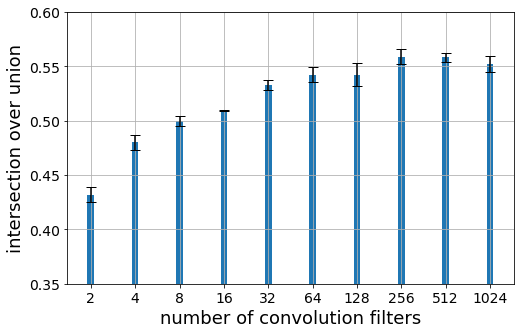

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8,5))
plt.rcParams.update({'font.size': 14})
width = 0.15
import numpy as np
sd = [0.4320,np.mean(n4),np.mean(n8),np.mean(n16),np.mean(n32),np.mean(n64),np.mean(n128),np.mean(n256),np.mean(n512),np.mean(n1024)]
asd = [np.std(n4),np.std(n4),np.std(n8),np.std(n16),np.std(n32),np.std(n64),np.std(n128),np.std(n256),np.std(n512),np.std(n1024)]
plt.grid()
plt.bar(['2','4','8','16','32','64','128','256','512','1024'], sd, width, label='VGG with attention modules',yerr=asd,capsize=5)
plt.ylabel('intersection over union',fontsize=18)
plt.xlabel('number of convolution filters',fontsize=18)
plt.ylim([0.35,0.60])
plt.savefig("localization_species_tuning.jpg")

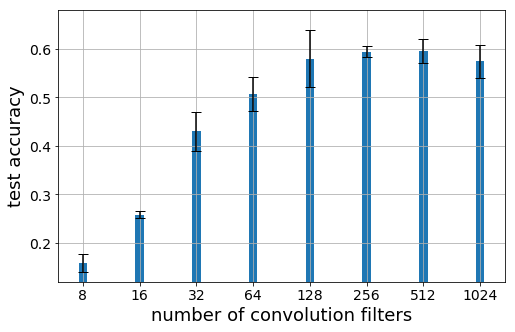

In [10]:
n8 = [0.1818,0.1556,0.1386]
n16 = [0.2674,0.2516,0.2564]
n32 = [0.3743,0.4444,0.4711]
n64 = [0.47,0.4963,0.5537]
n128 = [0.4973,0.6296,0.6116]
n256 = [0.5775,0.6000,0.6033]
n512 = [0.5615,0.6148,0.6116]
n1024 = [0.5561,0.6222,0.5455]
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8,5))
plt.rcParams.update({'font.size': 14})
width = 0.15
import numpy as np
sd = [np.mean(n8),np.mean(n16),np.mean(n32),np.mean(n64),np.mean(n128),np.mean(n256),np.mean(n512),np.mean(n1024)]
asd = [np.std(n8),np.std(n16),np.std(n32),np.std(n64),np.std(n128),np.std(n256),np.std(n512),np.std(n1024)]
plt.grid()
plt.bar(['8','16','32','64','128','256','512','1024'], sd, width, label='VGG with attention modules',yerr=asd,capsize=5)
plt.ylabel('test accuracy',fontsize=18)
plt.xlabel('number of convolution filters',fontsize=18)
plt.ylim([0.12,0.68])
plt.savefig("unique_dense_tuning.jpg")

In [53]:
with open('resnet-predictions.pckl','wb') as file:
    pickle.dump((train_pred,test_pred),file)

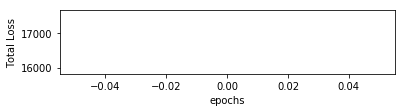

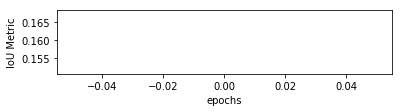

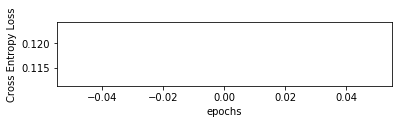

In [21]:
plt.subplot(3,1,1)
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('Total Loss')
plt.show()
plt.subplot(3,1,2)
plt.plot(history.history['localization_output_iou_metric'])
plt.xlabel('epochs')
plt.ylabel('IoU Metric')
plt.show()
plt.subplot(3,1,3)
plt.plot(history.history['classification_output_loss'])
plt.xlabel('epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [15]:
from sklearn import preprocessing
import numpy
le = preprocessing.LabelEncoder()
le.classes_ = numpy.load('classes.npy')

In [22]:
idx = np.random.randint(low=0,high=np.array(test_images).shape[0])
bb,classify = model.predict(np.expand_dims(np.array(test_images)[idx],0))
[[xmin,ymin,xmax,ymax]]= bb
img = cv2.rectangle(np.array(test_images)[idx], (xmin,ymin), (xmax,ymax), (0,255,0), 4)
pil_im = Image.fromarray(img)
a = np.argmax(classify,axis=1)[0]
label = le.inverse_transform(np.argmax(classify,axis=1))
#print(label[0])
#y = ymin - 15 if ymin - 15 > 15 else ymin + 15
plt.title("Predicted: "+label[0]+", Actual: "+le.inverse_transform(np.argmax(test_predictions[idx])))
plt.imshow(pil_im)
print(label[0])

/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


IndexError: list index out of range

In [ ]:
# print(np.mean(np.array(test_cvscores)[:,1]))
# print(np.std(np.array(test_cvscores)[:,1]))

# print(np.mean(np.array(validation_cvscores)[:,1]))
# print(np.std(np.array(validation_cvscores)[:,1]))

In [ ]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)!=predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

In [ ]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)==predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_test, predicted_labels,labels=np.unique(labels_))
print(cm)

In [ ]:
confusion_matrix(labels_test,predicted_labels)

labels_=list(np.unique(labels_test))
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels_)
ax.set_yticklabels([''] + labels_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()